In [53]:
from google.colab import drive
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img

In [32]:
RANDOM_STATE = 42
"""стандартное значение сида"""

In [6]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Задаём пути к файлам

In [7]:
data_path = Path("/content/drive/MyDrive/WorldSkillsCompetition/Potholes Dataset")
folder1_path = data_path / "Dataset 1 (Simplex)"
folder2_path = data_path / "Dataset 2 (Simplex)"

In [11]:
@dataclass
class PotImage:
    """Датакласс для хранения данных об изображении"""
    path: str
    """Путь к файлу"""
    boxes: List[Tuple[int, int, int, int]]
    """
    Список баунд боксов в формате (x0, y0, w, h), где (x0, y0) - точка левого 
    верхнего угла, а (w, h) - длина и ширина бокса
    """

    def get_normal_boxes(self) -> List[Tuple[int, int, int, int]]:
        """Возвращает список баунд боксов с координатами левого верхнего угла и нижнего правого"""
        return [(x[0], x[1], x[0] + x[2], x[1] + x[3]) for x in self.boxes]

In [13]:
def parse_dir(path: Path) -> List[PotImage]:
    """Принимает путь до папки, возвращает список со всеми картинками в ней"""
    return [PotImage(path=str(path / img), boxes=[]) for img in path.glob("*.JPG")]

In [14]:
def parse_annotations(path: Path) -> List[PotImage]:
    """Принимает путь до аннотации, возращает список картинок, упомянутых в аннотации"""
    data = []
    item_re = r"(.*\.bmp) ([\d]{1,}) ([\d ]*)"
    with open(path, "r", encoding="utf-8") as f:
        for item in f.readlines():
            img_path, num_boxes, boxes = re.match(item_re, item).group(1, 2, 3)
            img_path = img_path.replace("\\", "/").replace(".bmp", ".JPG")
            num_boxes = int(num_boxes)
            boxes = list(map(int, boxes.split()))
            for i in range(num_boxes):
                boxes[i] = (boxes[i * 4], boxes[i * 4 + 1], boxes[i * 4 + 2], boxes[i * 4 + 3])
            data.append(PotImage(img_path, boxes[:num_boxes]))
    return data

In [23]:
class ImageFolder:
    """Класс для хранения кластеров изображений"""
    path: Path
    """Путь до папки (либо с аннотацией, либо с картинками)"""
    data: List[PotImage]
    """Список изображений в кластере"""

    def __init__(self, folder_path: Path, annotation_path: str = None):
        """
        Параметры:
            folder_path - str, путь до папки
            annotation_path (default: None) - str or None, путь до аннотации, если таковая есть
        """
        self.path = folder_path
        if annotation_path is None:
            self.data = parse_dir(folder_path)
        else:
            self.data = parse_annotations(folder_path / annotation_path)

    def get_paths(self) -> List[str]:
        """Возвращает список абсолютных путей для всех изображения кластера"""
        return [str(self.path / img.path) for img in self.data]

Загружаем изображения с первого датасета

In [24]:
pos_col, neg_col = ImageFolder(folder1_path, "simpleTrainFullPhotosSortedFullAnnotations.txt"), ImageFolder(folder1_path / "Train data/Negative data")

Создаём датафрейм с данными об изображениях

In [30]:
df = pd.DataFrame()
df["path"] = pos_col.get_paths() + neg_col.get_paths()
df['labels'] = np.concatenate((np.ones(len(pos_col.data)), np.zeros(len(neg_col.data))))

Разделяем его на train и test подвыборки (4:1)

In [34]:
img_path_train, img_path_test, label_train, label_test = train_test_split(df["path"], df["labels"], train_size=0.8, random_state=RANDOM_STATE)

In [35]:
print(f"""Len of train: {len(label_train)}
Len of test: {len(label_test)}""")

Len of train: 4048
Len of test: 1012


Загружаем изображения для работы с Keras

N.B.: изображения при обработке сжимаются до стандартных 244x244 для VGG16.

In [38]:
image_generator = ImageDataGenerator(rescale=1 / 255)

In [40]:
train_data = image_generator.flow_from_dataframe(
    pd.DataFrame.from_dict({"x": img_path_train, "y": label_train.astype("str")}),
    x_col='x',
    y_col='y',
    target_size=(244, 244),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=RANDOM_STATE,
)

Found 4048 validated image filenames belonging to 2 classes.


In [41]:
test_data = image_generator.flow_from_dataframe(
    pd.DataFrame.from_dict({"x": img_path_test, "y": label_test.astype("str")}),
    x_col='x',
    y_col='y',
    target_size=(244, 244),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=RANDOM_STATE,
)

Found 1012 validated image filenames belonging to 2 classes.


Создаём модель VGG16 (однако с упрощенной архитектурой для более быстрого обучения). Также для лучших результатов вместо softmax (лучше подходящей для многоклассовой классификации) в последнем слое была использована сигмоида.

In [54]:
model = Sequential([
    Conv2D(filters=8, input_shape=(244, 244, 3), kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

Для ускорения выбран Adam, который *эффективен в вычислениях, требует мало памяти и хорошо подходит для задач, которые являются большими с точки зрения данных/параметров*

In [55]:
opt = Adam()
model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 244, 244, 8)       224       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 122, 122, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 122, 122, 16)      1168      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 61, 61, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 32)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Обучение на 8 эпохах, опять же, для ускорения

In [59]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
hist = model.fit(
    train_data,
    steps_per_epoch=20,
    validation_data=test_data,
    validation_steps=10,
    epochs=8,
    callbacks=[checkpoint]
)

Epoch 1/8
20/20 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.7000 
Epoch 1: loss improved from inf to 0.59005, saving model to vgg16_1.h5
20/20 [==============================] - 486s 25s/step - loss: 0.5901 - accuracy: 0.7000 - val_loss: 0.4844 - val_accuracy: 0.8406
Epoch 2/8
20/20 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.8172 
Epoch 2: loss improved from 0.59005 to 0.46029, saving model to vgg16_1.h5
20/20 [==============================] - 434s 22s/step - loss: 0.4603 - accuracy: 0.8172 - val_loss: 0.4064 - val_accuracy: 0.8469
Epoch 3/8
20/20 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8328 
Epoch 3: loss improved from 0.46029 to 0.42114, saving model to vgg16_1.h5
20/20 [==============================] - 400s 20s/step - loss: 0.4211 - accuracy: 0.8328 - val_loss: 0.3864 - val_accuracy: 0.8625
Epoch 4/8
20/20 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8656 
Epoch 4: l

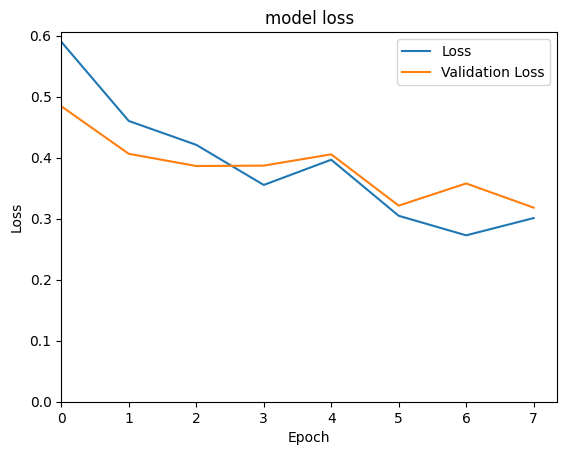

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss", "loss", "Validation Loss"])
ax.set_ylim(ymin=0)
ax.set_xlim(left=0)
plt.show()

Тестирование массивов данных

In [74]:
label_pred = model.predict(test_data)

32/32 [==============================] - 238s 7s/step


In [89]:
pd.DataFrame.from_dict({"pred": label_pred.reshape(-1), "true": label_test})

,pred,true
2428,0.164876,0.0
1430,0.356228,1.0
242,0.993853,1.0
3604,0.997626,0.0
3966,0.997505,0.0
...,...,...
2411,0.084070,0.0
1378,0.108639,1.0
4804,0.046790,0.0
881,0.094256,1.0


In [106]:
def predict_image(path: Path):
    """Выводит интерфейс распознавания для картинки"""
    img = load_img(str(path), target_size=(244,244))
    img = np.asarray(img)
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    from keras.models import load_model
    saved_model = load_model("vgg16_1.h5")
    output = saved_model.predict(img)
    print("Яма" if output[0][0] <= .5 else "Нет ямы")

Тестирование отдельных изображений

1/1 [==============================] - 0s 197ms/step
Нет ямы


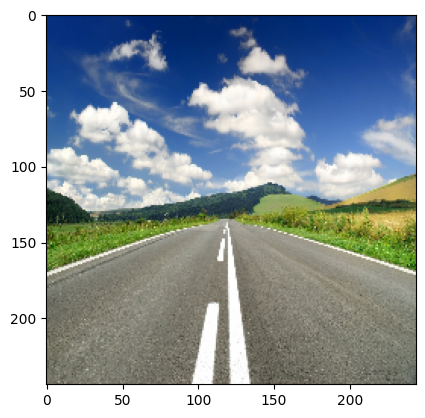

In [107]:
predict_image("/content/1675418142_gas-kvas-com-p-doroga-fonovii-risunok-4.jpg")

1/1 [==============================] - 0s 114ms/step
Яма


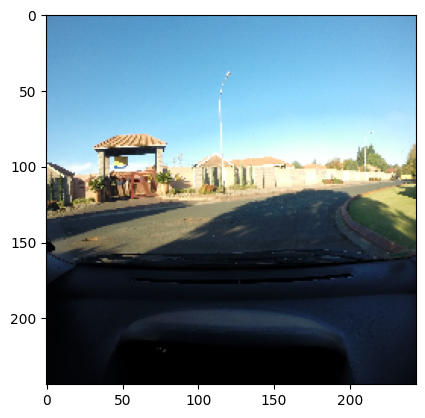

In [108]:
predict_image(folder1_path / "Train data/Positive data/G0010036.JPG")

<Axes: >

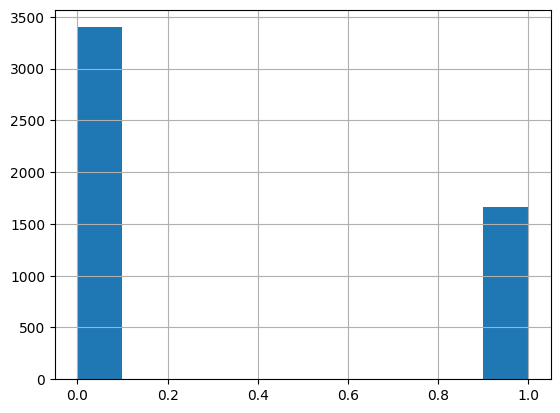

In [110]:
df.labels.hist()